In [1]:
import math 
import numpy as np 
import matplotlib.pyplot as plt 
import graphviz
%matplotlib inline


# isInstance()
The isinstance() function returns True if the specified object is of the specified type, otherwise False.

### ->  isinstance(object, type)


# Assert()
assert condition [, Error Message]

In [30]:
class value:
    def __init__(self , data , children=(),operation = '',label = ''):
        self.data = data
        self.previous = set(children)
        self.operation = operation
        self.label = label
        self.grad = 0.0
        self._backward = lambda : None   #f(x) -> x   let ideal function 

    def __repr__(self):
       return f"Value(data={self.data}, grad={self.grad})"
    
    # add operations value objects 

    def __add__(self , other):
        other = other if isinstance(other , value) else value(other)
       # The isinstance() function returns True -
       # -if the specified object is of the specified type, otherwise False
        out = value(self.data + other.data , (self, other) , '+')             # '+'  calls __add__() internally!! 
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward 
        return out
    
    def __mul__(self , other):
        other = other if isinstance(other , value) else value(other)
        out = value(self.data * other.data,(self , other) ,'*')
        def _backward():
            self.grad += other.data * out.grad 
            other.grad += self.data * out.grad
        out._backward = _backward
        return out 
    
    def __radd__(self, other):
        return self.__add__(other)
    
    def __rmul__(self, other):
        return self * other 
    
    def __sub__(self , other):
        return self +(-other)
    
    def __rsub__(self, other): # other - self
        return other + (-self)
    
    def __neg__(self):
        return self * -1
    
    def __hash__(self):
        return hash(id(self))  # Ensure hashability

    def __eq__(self, other):
        return id(self) == id(other)
        
    def __pow__(self , other):
        assert[isinstance(other , (int , float)), "only support int,float powers"]  #assert condition [, Error Message] 
        out = value(self.data**other, (self , ), f'**{other}')
        def _backward():
            self.grad += other * (self.data ** (other-1)) * out.grad

        out._backward = _backward
        return out 
    
    def __truediv__(self , other):
       return (self * other**-1)
    
    def __rtruediv__(self, other): # other / self
        return other * self**-1
    
    def tanh(self):  # Hyperbolic tangent
        x = self.data 
        # x = max(min(x, 20), -20)
        t = (math.exp(x) - math.exp(-x)) / (math.exp(x) + math.exp(-x))
        out = value(t , (self, ) , 'tanh')  
        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward  # store the function 
        return out 
    
    def exp(self):
        x = self.data 
        out = value(math.exp(x), (self ,) , 'exp')
        def _backward():
            self.grad = out.data * out.grad 
        out._backward = _backward
        return out 
    
    def backward(self):
        self.grad = 1.0  # base case 
        topo = []
        visited = set()
        #  topological order all of the children in the graph
        def build_top(v):
            if v not in visited:
                visited.add(v)
                for child in v.previous:
                    build_top(child)
                topo.append(v)
        build_top(self)
        self.grad = 1
        for node in reversed(topo):
            node._backward()

In [3]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()

  def build(v):
    # nodes = tuple(nodes)
    # print(type(nodes)) -> set 
    if v not in nodes:
      nodes.add(v)
      for child in v.previous:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right

  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name=uid , label="{%s | data %.04f | grad %0.4f}"%(n.label , n.data , n.grad), shape  = 'record')
    if n.operation:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n.operation, label = n.operation)
      # and connect this node to it
      dot.edge(uid + n.operation, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2.operation)
  return dot



In [4]:
h = value(0.000001)
a = value(2.0 , label = 'a')
b = value(-3.0 , label = 'b')
c = value(10.0 , label = 'c')
d = a*b ; d.label= 'd'
e = c+d; e.label='e'
f = value(-2.0) ; f.label= 'f'
L = e * f ; L.label= 'L'


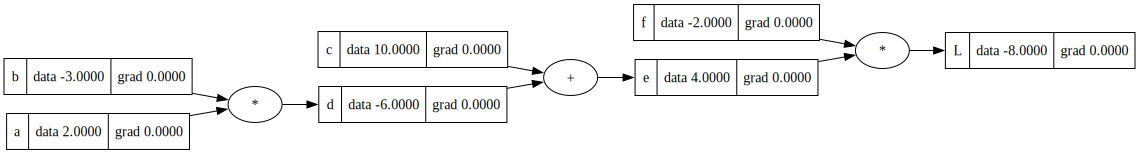

In [5]:
draw_dot(L)

In [6]:
# grad 
# L = e * f 

# dL/de = f 
# dL/df = e


# d+c = e 
# de/dd  = 1 
# de/dc = 1 
# dL/dc = dL/de * de/dc = e.grad * 1 
# dL/dd = dL/de * de/dd = e.grad * 1 

# d = a * b 

# dd/db = a 
# dd/da= b 
# dL/db = dL/de * de/dd * dd/db
# dL/da = dL/de * de/dd * dd/da


L.grad = 1
e.grad = f.data 
f.grad = e.data 
d.grad = e.grad * 1 
c.grad = e.grad * 1 

b.grad = e.grad * 1 * a.data 
a.grad = e.grad * 1 * b.data 








In [7]:
a.data += 0.01 * a.grad 
b.data += 0.01 * b.grad 
c.data += 0.01 * c.grad 
f.data += 0.01 * f.grad


d = a*b
e = c+d
f = value(-2.0)
L = e * f 



In [8]:
# to check the derivatove == grad  :::::: extra function 

def lol():
    h = 0.00001
    a = value(2.0 , label = 'a')
    b = value(-3.0 , label = 'b')
    c = value(10.0 , label = 'c')
    d = a*b ; d.label= 'd'
    e = c+d; e.label='e'
    f = value(-2.0) ; f.label= 'f'
    L = e * f ; L.label= 'L'

    L1 = L.data
    a = value(2.0 , label = 'a')
    b = value(-3.0 , label = 'b')
    c = value(10.0, label = 'c')
    d = a*b   ; d.label= 'd'
    e = c+d; e.label='e'
    f = value(-2.0) ; f.label= 'f'
    L = e * f ; L.label= 'L'
    L2 = L.data + h 
    print((L2 - L1)/h)

lol()
    
    

0.9999999999621422


In [9]:

# Example 2 : manual backpropogation 

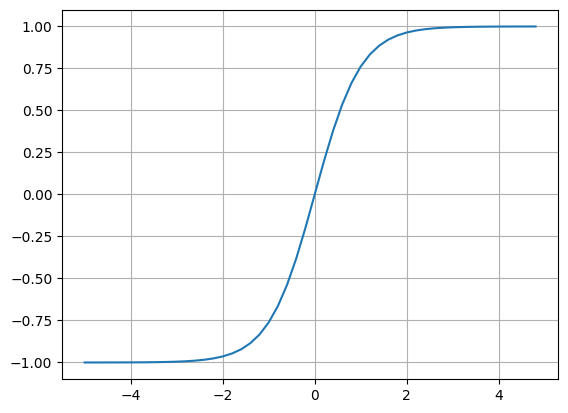

In [10]:
# tanh()
plt.plot(np.arange(-5,5,0.2) , np.tanh(np.arange(-5,5,0.2)))
plt.grid()

In [11]:
x1 = value(1, label='x1')
x2 = value(2, label='x2')
w1 = value(-1.0 , label='w1' )
w2=  value(-2.0  , label= 'w2')
b1 = value(2 , label='b1')

x1w1 = x1 * w1 ; x1w1.label ='x1 * w1'
x2w2 = x2 * w2 ; x2w2.label ='x2 * w2'

x1w1x2w2 = x1w1 + x2w2 ; x1w1x2w2.label = 'x1w1 + x2w2'

n = x1w1x2w2 + b1 ; n.label = 'n'
o = n.tanh() ; o.label = 'output'
o.backward()


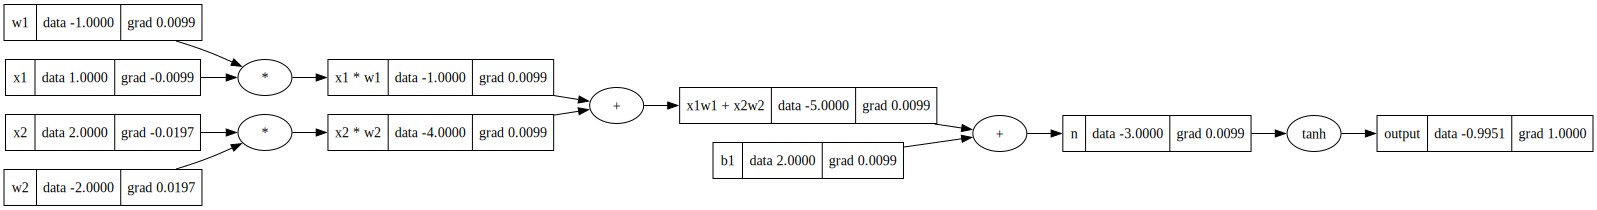

In [12]:
draw_dot(o)

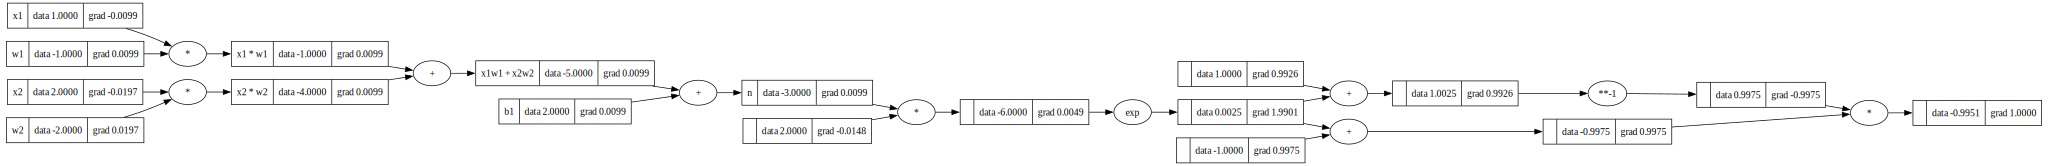

In [13]:
x1 = value(1.0, label='x1')
x2 = value(2.0, label='x2')
w1 = value(-1.0,label='w1' )
w2=  value(-2.0,label= 'w2')
b1 = value(2.0,label='b1')

x1w1 = x1 * w1 ; x1w1.label ='x1 * w1'
x2w2 = x2 * w2 ; x2w2.label ='x2 * w2'

x1w1x2w2 = x1w1 + x2w2 ; x1w1x2w2.label = 'x1w1 + x2w2'

n = x1w1x2w2 + b1 ; n.label = 'n'

#-----------------------------------
# o = n.tanh() ; o.label = 'output'
e = (2 * n ).exp()
o.label = 'o'
o = (e - 1) / (e + 1)
o.backward()
draw_dot(o)

In [14]:
# manual backprogate 

o.grad = 1   # dx/dx = 1 (base case)
#do/dn = d/dn tanh(x) = 1- (tanh(x))**2
n.grad = 1 - (o.data**2)
x1w1x2w2.grad = n.grad * 1 
b1.grad = n.grad * 1 
x1w1.grad = 1* 1 * n.grad
x2w2.grad = 1* 1 * n.grad

x1.grad = w1.data * x1w1.grad
w1.grad = x1.data * x1w1.grad 

x2.grad = w2.data * x2w2.grad
w2.grad = x2.data * x2w2.grad 



In [15]:
o.grad = 1.0 # base case 

In [16]:
# Manually calling functions 
o._backward()
n._backward()
x1w1x2w2._backward()
x2w2._backward()
x1w1._backward()


In [17]:
# Bug 

a =value(1 , label='a')
b = a + a ; b.label = 'b'
b.backward()

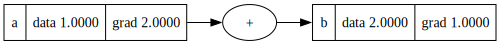

In [18]:
draw_dot(b)   # wrong ;; a.grad ==2 ??  multi case chain rule  to add the chain ::: +=

In [19]:
import torch
x1 = torch.tensor([1.0]).double() ; x1.requires_grad = True   
# bcz individual leaf nodes torch grad == false defalt 
x2 = torch.tensor([2.0]).double() ; x2.requires_grad = True
w1 = torch.tensor([-1.0]).double(); w1.requires_grad = True
w2 = torch.tensor([-2.0]).double() ; w2.requires_grad = True
b = torch.tensor([2.0]).double(); b.requires_grad = True
n = x1*w1+ x2*w2 +b
o = torch.tanh(n)
o.backward()

print(o.data.item())
print('-----')
print('x1 grad  : ' , x1.grad.item())
print('w1 grad: ' ,w1.grad.item())
print('x2 grad : ', x2.grad.item())
print('w2 grad : ' , w2.grad.item())


-0.9950547536867305
-----
x1 grad  :  -0.009866037165440166
w1 grad:  0.009866037165440166
x2 grad :  -0.019732074330880332
w2 grad :  0.019732074330880332


In [20]:
import random
# single neurone : 
class Neuron:
    def __init__(self , nin):  # nin : no of inputs 
        self.w = [value(random.uniform(-1 , 1 )) for _ in range(nin)]
        self.b = value(random.uniform(-1,1))

    def __call__(self, x):   # a(x) : a called  __call__(a) 
        # w * x + b 
        act = sum(((xi * wi) for xi , wi in zip(self.w ,x)) ,self.b)   #zip(x -> w )
        out = act.tanh()
        return out 
    
    def parameters(self):
        return self.w + [self.b]
    
# one layers :::: multi neurons 

class Layer:
    def __init__(self , nin , non):
        self.neurons  = [Neuron(nin) for _ in range(non)]

    def __call__(self , x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
    
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]
        # params = []
        # for neuron in self.neurons:
        #     ps = neuron.parameters()
        #     params.extend(ps)
        #     return ps  
# Multi layers ::::::::::
class MLP:
    def __init__(self , nin , nouts):
        sz = [nin]+ nouts
        self.layers = [Layer(sz[i] , sz[i+1]) for i in range(len(nouts))] 
    def __call__(self ,x):
        for layer in self.layers:
          x = layer(x)
        return x 
    
    def parameters(self):
       return [p for layer in self.layers for p in layer.parameters()]

In [21]:
# draw_dot(n(x))

In [22]:
# neurone 
x = [1,2,3 ]
n = Neuron(3)
n(x)

Value(data=-0.9857024340440561, grad=0.0)

In [23]:
# layers 

x =[1,2,3]
n= Layer(3,3)
n(x)


[Value(data=-0.024320949576734988, grad=0.0),
 Value(data=-0.9995635146353186, grad=0.0),
 Value(data=-0.6192617385595702, grad=0.0)]

In [24]:
# MLP 
# xs = [1,2,3]
# n = MLP(3,[4,4,1])
# n(xs)


In [25]:
# draw_dot(n(xs))

In [26]:
n = MLP(3,[4,4,1])
xs = [
    [1.0,2.0,3.9],
    [2.1,3.3,1.4],
    [1.9,2.4,2.4],
    [0.5,1.0,1.5]
]
ys = [1.1,-1.0,1.8,1.5]


In [27]:
for k in range(10):
    #forward
    yp = [n(x) for x in xs]
    loss = sum((j-i)**2 for i,j in zip(ys,yp))
    #backword 
    for p in n.parameters():
        p.grad = 0.0
    loss.backward()

    # Gradient decent 
    for p in n.parameters():
        p.data += -0.1 * p.grad   # -learning rate to minimise tge loss 
    
    print(k ,loss.data)


0 16.42873347569406
1 7.205473519870276
2 4.794124896963526
3 4.753958674534524
4 4.676068025976748
5 4.436727256548279
6 4.027521702371326
7 3.599124569104294
8 7.5244112076647545
9 4.828369408685958


In [28]:
yp

[Value(data=0.9750486692025662, grad=-0.24990266159486785),
 Value(data=0.9615774391716676, grad=3.923154878343335),
 Value(data=0.9750234799723762, grad=-1.6499530400552478),
 Value(data=0.9667230877360784, grad=-1.0665538245278432)]

In [29]:
loss

Value(data=4.828369408685958, grad=1.0)